# Code for importing, analyzing, and plotting Sensorlog data from smartphone
Using a software Sensorlog v1.9.6, outputs about 16 kb/s worth of data, 70 columns. Smartphone: iphone 5s.

Time stamping issues were a little funny, maybe look into the time stamps (since reset) that actually are paired with each measurement (such as accelerometer).

The z-accelerometer deals with acceleration along the face of the phone. For face-up phone laying on the ground, >-1g means phone is accelerating downward, and <-1g means accelerating upward.

I had noticed that the elevator decends quite rapidly, and I was curious to see how well I could measure it. As I was going down the elevator, I turned on SensorLog, and it spit out the accelerometer data at ~30 Hz. I laid the phone on the floor just before it descended. 

Then I wondered if I could take integrals of this acceleration function (used a free-body diagram to relate the measurement from the phone to an actual acceleration) and estimate the actual height of the apartment (10th floor). My estimate is that the height is ~20 meters, which would be about 7 floors if you assume 3 meters per floor. So it is not perfect, but this was also a pretty rough test. Now I have all the code ready to work with the data. Looks like about 13-14 seconds total journey from beginning descent to doors open. 

I cannot understand the source of error that would explain why my estimate of height is so far off though. I wonder if it would improve the measurement if I taped the phone to the floor. perhaps it has something to do with the padding of my case, buffering the measured acceleration... But if I am to believe that the floor is 30 meters above ground, then I'm underestimating by ~30%. Might be interesting to use a plumb-bob method. Seems like there should be an easier way to measure the height of the apartment. Maybe using similar triangles from across the street or something similar....

One interesting thing I noticed was that on the way down there is a slight upward acceleration (not quite a constant speed for those ~6 seconds)...

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
# from matplotlib import interactive
# interactive(True)
%matplotlib nbagg

In [2]:
# load data file
df = pd.read_csv('my_iOS_device_1_2017-10-22_00-11-48_-0700.csv')
# df = pd.read_csv('my_iOS_device_1_2017-10-22_00-13-04_-0700.csv')
lenFile = len(df)
df['date'] = pd.to_datetime(df['loggingTime(txt)'])
print('start:',df['date'][0])
print('stop:',df['date'][lenFile-1])
df.index = df['date']
df.index = df.index + pd.DateOffset(hours=-7)


start: 2017-10-22 07:11:48.800000
stop: 2017-10-22 07:12:24.353000


In [3]:
df['ns'] = df.index.astype('int64') #//1e9

In [4]:
# df['loggingTime(txt)'][0:3]
# df['ns'][1]

<IPython.core.display.Javascript object>


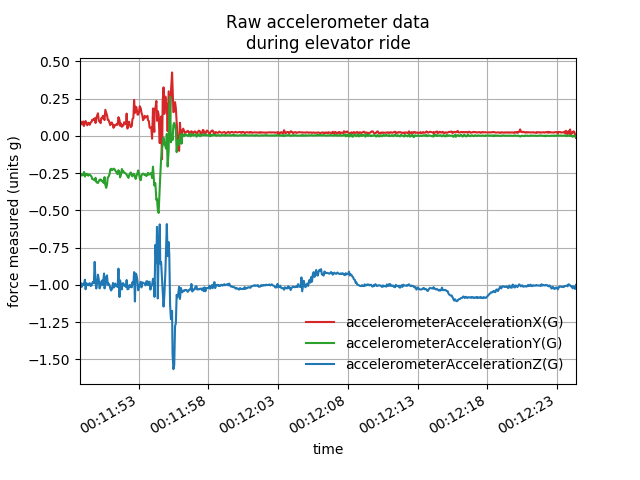

In [32]:
df['accelerometerAccelerationX(G)'].plot(color='tab:red')
df['accelerometerAccelerationY(G)'].plot(color='tab:green')
df['accelerometerAccelerationZ(G)'].plot(color='tab:blue')
# plt.plot(beta, 1 * np.ones(len(beta)), 'k--',label = 'beta=0')
plt.legend(frameon=False,loc='best') 
plt.ylabel('force measured (units g)')
plt.xlabel('time')
plt.title('Raw accelerometer data\nduring elevator ride')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


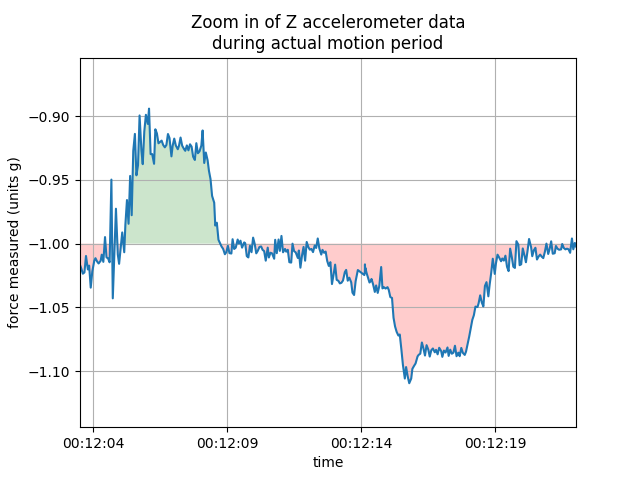

In [33]:
fig, ax = plt.subplots()
ax.plot(df.index,df['accelerometerAccelerationZ(G)'])
plt.ylabel('force measured (units g)')
plt.xlabel('time')
plt.title('Zoom in of Z accelerometer data\nduring actual motion period')
plt.grid()
# fill in between curve and a line..
ax.fill_between(df.index, -1,df['accelerometerAccelerationZ(G)'],
                where=df['accelerometerAccelerationZ(G)'] >= -1,
                facecolor='green', alpha=0.2, interpolate=True)
ax.fill_between(df.index, -1,df['accelerometerAccelerationZ(G)'],
                where=df['accelerometerAccelerationZ(G)'] < -1,
                facecolor='red', alpha=0.2, interpolate=True)
plt.show()



## Calculating integrals to retrieve velocity and position

<IPython.core.display.Javascript object>


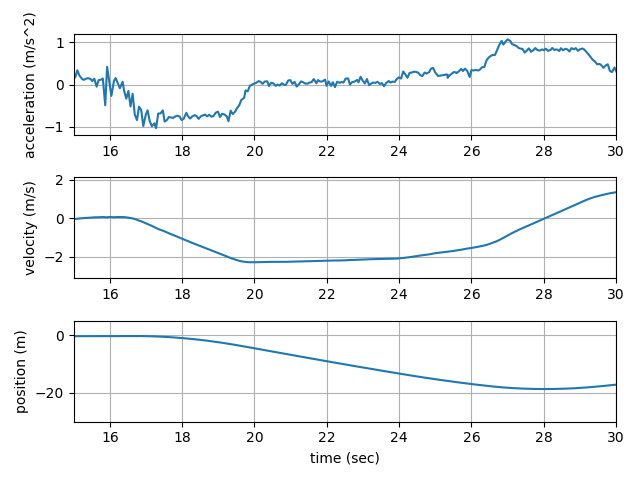

In [40]:
time_sec=df['ns'].values * 10**-9
timezero = time_sec[0]

df['AccelActual'] = -(df['accelerometerAccelerationZ(G)']+1)*9.8  # m/s^2
v = sp.integrate.cumtrapz(df['AccelActual'], x=time_sec)-2+1.05 #  ,initial=0)
x = sp.integrate.cumtrapz(v, time_sec[1:lenFile])+10.5 #,initial=0)

xlim_start = 15
xlim_stop = 30
timezero = time_sec[0]

plt.subplot(3, 1, 1)
plt.plot((time_sec[0:lenFile]-timezero),df['AccelActual'])
plt.ylim([-1.2,1.2])
plt.xlim([xlim_start,xlim_stop])
plt.ylabel('acceleration (m/s^2)')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot((time_sec[1:lenFile]-timezero),v)
plt.xlim([xlim_start,xlim_stop])
plt.ylabel('velocity (m/s)')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot((time_sec[2:lenFile]-timezero),x+3)
plt.xlim([xlim_start,xlim_stop])
plt.ylim([-30,5])
plt.ylabel('position (m)')

plt.xlabel('time (sec)')
plt.grid()
plt.tight_layout()
plt.show()

## simplified model
In this model, I make a box approximation of the above acceleration data:

* t0 is the time during which the elevator is accelerating.
* t1 is the "constant velocity" portion -- no acceleration.
* t2 is the 'decelation' period.

In [36]:
g = 9.8
t0 = 2.9
t1 = 6.7
t2 = 3.5

x0 = .5*0.08*g*t0**2
x1 = (0.08*g*t0)*t1
x2 = (0.08*g*t0)*t2 - 0.5*(0.08*g)*t2**2
print('x0 = ',x0)
print('x1 = ',x1)
print('x2 = ',x2)

x0 =  3.29672
x1 =  15.233120000000001
x2 =  3.1555999999999997


In [37]:
total_dist = x0+x1+x2
print('total distance traveled (estimate) = %2.2f meters'%(total_dist))

total distance traveled (estimate) = 21.69 meters
